## Import library

In [36]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from collections import Counter
from google.colab import drive
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.exposure import equalize_hist
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import MobileNetV2

## Load Data

In [37]:
drive.mount('/content/drive')
PROJECT_ROOT_DIR = "/content/drive/MyDrive/"
data_path = os.path.join(PROJECT_ROOT_DIR, 'tensorflow_data/tensorflow_data/')
os.makedirs(data_path, exist_ok=True)
print("Using directory: ", data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using directory:  /content/drive/MyDrive/tensorflow_data/tensorflow_data/


In [38]:
flow_data_set_linear = tfds.load('elg7186_projectdata/linear_movement_rotate', data_dir=data_path)
flow_data_set_rotation = tfds.load('elg7186_projectdata/rotation_rotate', data_dir=data_path)
flow_data_set_fixed = tfds.load('elg7186_projectdata/fixed_random_rotate', data_dir=data_path)

## Data Extraction

In [39]:
def extract_data_from_dataset(dataset):
    iter_data = iter(dataset['train'])
    df = pd.DataFrame()

    for i in range(len(dataset['train'])):
        train_data = next(iter_data)
        for j in range(len(train_data['video'])):
            df = df.append({
                'img': np.array(train_data['video'][j, :, :, :]),
                'y': train_data['instances']['category'].numpy()
            }, ignore_index=True)

    return df

df_linear = extract_data_from_dataset(flow_data_set_linear)
df_rot = extract_data_from_dataset(flow_data_set_rotation)
df_fixed = extract_data_from_dataset(flow_data_set_fixed)

<ipython-input-39-ed753ec7b637>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-39-ed753ec7b637>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-39-ed753ec7b637>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-39-ed753ec7b637>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-39-ed753ec7b637>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-39-ed753ec7b637>:8: FutureWarning: The frame.appen

## Data Visualization

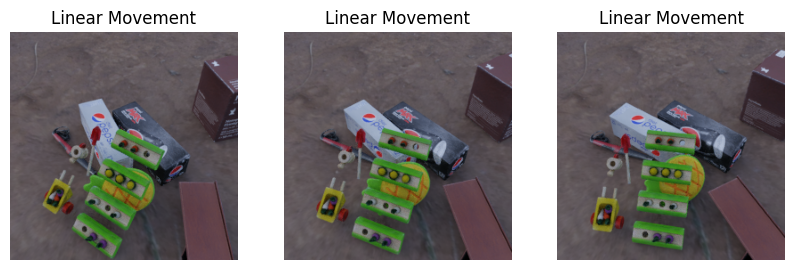

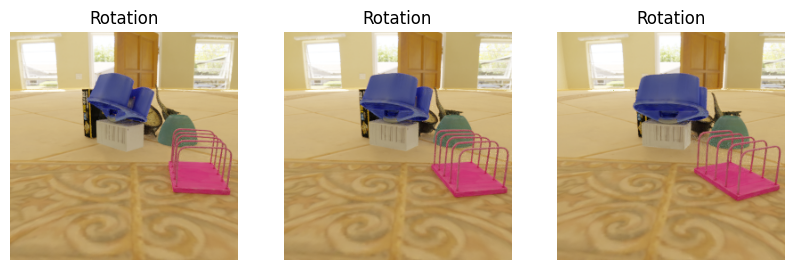

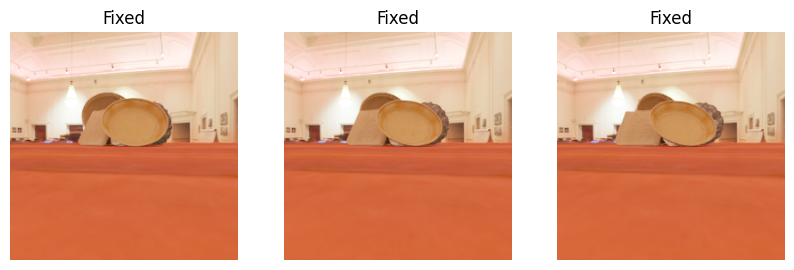

In [40]:
def visualize_samples(df, title):
    fig, ax = plt.subplots(1, 3, figsize=(10, 10))
    for i in range(3):
        ax[i].imshow(df['img'][i])
        ax[i].set_title(title)
        ax[i].axis('off')
    plt.show()

visualize_samples(df_linear, 'Linear Movement')
visualize_samples(df_rot, 'Rotation')
visualize_samples(df_fixed, 'Fixed')

## Data Concatenation

In [41]:
df = pd.concat([df_linear, df_fixed, df_rot], ignore_index=True)
most_common_class = Counter([item for sublist in df['y'] for item in sublist]).most_common(1)[0][0]
df['y'] = df['y'].apply(lambda x: 1 if most_common_class in x else 0)

In [42]:
df.sample(5)

,img,y
2153,"[[[167, 74, 46], [166, 74, 46], [165, 69, 41],...",0
1419,"[[[192, 81, 47], [196, 80, 47], [200, 82, 47],...",0
595,"[[[197, 214, 229], [196, 214, 229], [197, 214,...",1
258,"[[[52, 61, 72], [52, 61, 71], [52, 60, 70], [5...",1
499,"[[[126, 119, 83], [128, 130, 93], [149, 155, 1...",1


## Image Preprocessing

In [43]:
def preprocess_image(img):
    # Enhancing the image
    enhanced_img = unsharp_mask(img)
    # Convert to grayscale
    gray_img = rgb2gray(enhanced_img)
    # Stack grayscale image 3 times
    stacked_img = np.repeat(gray_img[..., np.newaxis], 3, axis=-1)
    return stacked_img

# Apply preprocessing to all images in the dataframe
df['img'] = df['img'].apply(preprocess_image)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


In [44]:
df.sample(5)

,img,y
1443,"[[[0.8232353911402422, 0.8232353911402422, 0.8...",0
1280,"[[[0.4357088414752126, 0.4357088414752126, 0.4...",0
1998,"[[[0.4457412137459425, 0.4457412137459425, 0.4...",1
223,"[[[0.7118472909795421, 0.7118472909795421, 0.7...",1
891,"[[[0.5707466120362803, 0.5707466120362803, 0.5...",1


# Display the steps of preprocessing

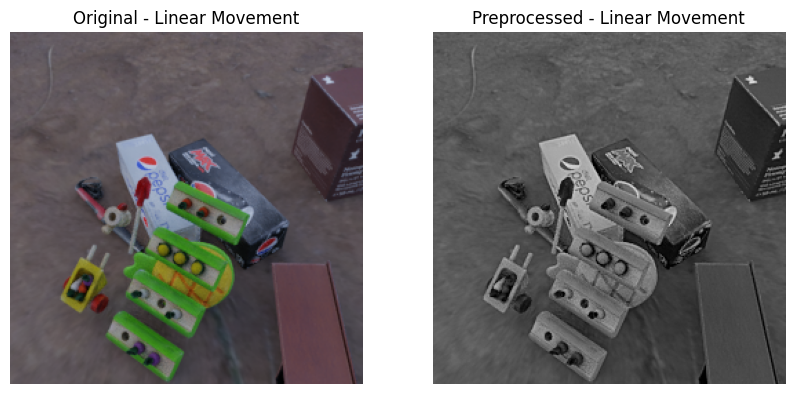

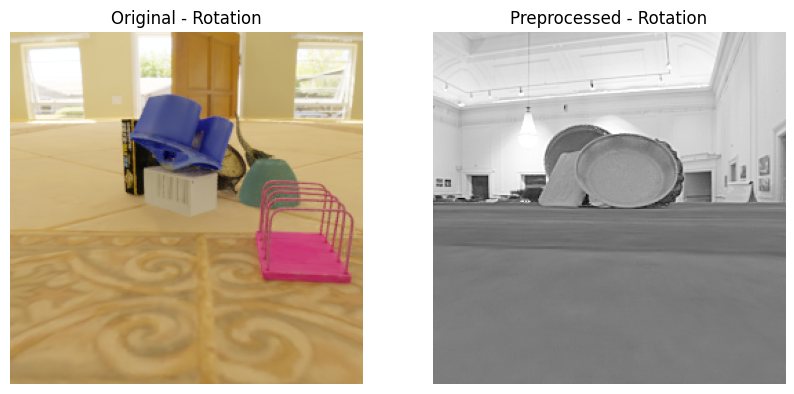

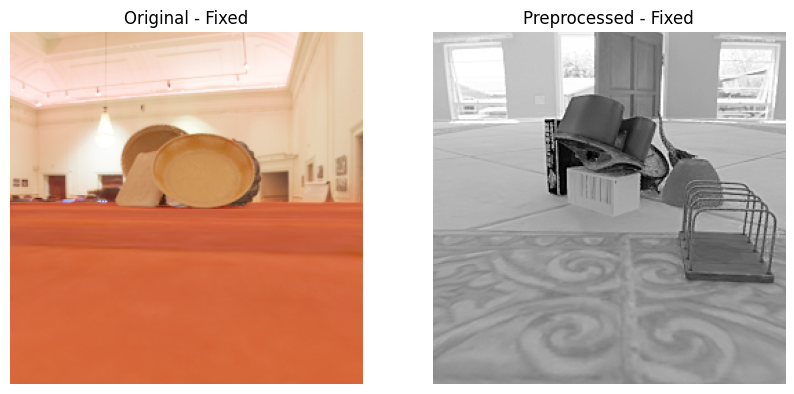

In [45]:
def compare_original_and_preprocessed(original_df, title, offset=0):
    # Original Image
    original_image = original_df['img'].iloc[0]

    # Corresponding preprocessed image using the offset and index
    preprocessed_image = df['img'].iloc[offset]

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(original_image)
    ax[0].set_title(f"Original - {title}")
    ax[0].axis('off')

    ax[1].imshow(preprocessed_image, cmap='gray')
    ax[1].set_title(f"Preprocessed - {title}")
    ax[1].axis('off')

    plt.show()

# Compare the original and preprocessed images from each original dataframe:
compare_original_and_preprocessed(df_linear, 'Linear Movement')
compare_original_and_preprocessed(df_rot, 'Rotation', offset=len(df_linear))
compare_original_and_preprocessed(df_fixed, 'Fixed', offset=len(df_linear)+len(df_rot))


## 8. Train-Test Split

In [46]:
X = np.array(df['img'].tolist())
y = df['y'].values

In [47]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Modeling

In [48]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # Evaluate the model on the training set
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    train_pred = (model.predict(X_train) > 0.5).astype(int)
    train_cm = confusion_matrix(y_train, train_pred)

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    val_pred = (model.predict(X_val) > 0.5).astype(int)
    val_cm = confusion_matrix(y_val, val_pred)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    test_pred = (model.predict(X_test) > 0.5).astype(int)
    test_cm = confusion_matrix(y_test, test_pred)

    # Plotting Confusion Matrices
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    sns.heatmap(train_cm, annot=True, cmap='Pastel2', ax=axs[0], fmt='g')
    axs[0].set_title('Training Confusion Matrix')
    axs[0].set_xlabel('Predicted Labels')
    axs[0].set_ylabel('Actual Labels')

    sns.heatmap(val_cm, annot=True, cmap='Pastel1', ax=axs[1], fmt='g')
    axs[1].set_title('Validation Confusion Matrix')
    axs[1].set_xlabel('Predicted Labels')
    axs[1].set_ylabel('Actual Labels')

    sns.heatmap(test_cm, annot=True, cmap='Pastel2', ax=axs[2], fmt='g')
    axs[2].set_title('Testing Confusion Matrix')
    axs[2].set_xlabel('Predicted Labels')
    axs[2].set_ylabel('Actual Labels')

    plt.tight_layout()
    plt.show()

In [49]:
def evaluate_model_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    def calculate_metrics(X, y):
        y_pred = model.predict(X)
        y_pred_classes = (y_pred > 0.5).astype(int)
        accuracy = accuracy_score(y, y_pred_classes)
        f1 = f1_score(y, y_pred_classes)

        loss = model.evaluate(X, y, verbose=0)[0]

        return accuracy, f1, loss

    train_accuracy, train_f1, train_loss = calculate_metrics(X_train, y_train)
    val_accuracy, val_f1, val_loss = calculate_metrics(X_val, y_val)
    test_accuracy, test_f1, test_loss = calculate_metrics(X_test, y_test)

    results = {
        'Training': {
            'Accuracy': train_accuracy,
            'F1 Score': train_f1,
            'Loss': train_loss
        },
        'Validation': {
            'Accuracy': val_accuracy,
            'F1 Score': val_f1,
            'Loss': val_loss
        },
        'Test': {
            'Accuracy': test_accuracy,
            'F1 Score': test_f1,
            'Loss': test_loss
        }
    }

    return results


In [50]:
def plot_learning_curves(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


## InceptionResNetV2

The InceptionResNetV2_Model function is intended for image classification tasks using the InceptionResNetV2 architecture. It takes in training, validation, and test data along with a pre-initialized InceptionResNetV2 model. The function then configures the model with an Adam optimizer using a binary cross-entropy loss function and accuracy as the metric. It fits the model to the provided training data for a specified number of epochs, utilizing the validation data for validation during training.

The function computes various evaluation metrics such as loss, accuracy, and confusion matrix for the training, validation, and test sets. Finally, it returns these evaluation metrics along with the trained model for further analysis.

In [51]:
def build_and_train_inception_resnet(X_train, y_train, X_val, y_val, X_test, y_test):
    # Load the Inception-ResNetV2 model
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Define the final model
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=32, validation_data=(X_val, y_val))

    # Evaluate the model on training data
    train_loss, train_accuracy = model.evaluate(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_cm = tf.math.confusion_matrix(y_train, y_train_pred > 0.5)

    # Evaluate the model on validation data
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    y_val_pred = model.predict(X_val)
    val_cm = tf.math.confusion_matrix(y_val, y_val_pred > 0.5)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    y_test_pred = model.predict(X_test)
    test_cm = tf.math.confusion_matrix(y_test, y_test_pred > 0.5)

    return train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, model, history


In [52]:
train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, model, history = build_and_train_inception_resnet(X_train, y_train, X_val, y_val, X_test, y_test)


Epoch 1/32
54/54 [==============================] - 20s 170ms/step - loss: 0.5841 - accuracy: 0.6869 - val_loss: 0.3597 - val_accuracy: 0.8611
Epoch 2/32
54/54 [==============================] - 5s 97ms/step - loss: 0.3687 - accuracy: 0.8420 - val_loss: 0.2783 - val_accuracy: 0.9028
Epoch 3/32
54/54 [==============================] - 5s 97ms/step - loss: 0.2814 - accuracy: 0.8935 - val_loss: 0.2332 - val_accuracy: 0.9444
Epoch 4/32
54/54 [==============================] - 5s 97ms/step - loss: 0.2357 - accuracy: 0.9172 - val_loss: 0.1962 - val_accuracy: 0.9676
Epoch 5/32
54/54 [==============================] - 5s 98ms/step - loss: 0.1956 - accuracy: 0.9375 - val_loss: 0.1703 - val_accuracy: 0.9676
Epoch 6/32
54/54 [==============================] - 5s 97ms/step - loss: 0.1785 - accuracy: 0.9456 - val_loss: 0.1586 - val_accuracy: 0.9676
Epoch 7/32
54/54 [==============================] - 5s 98ms/step - loss: 0.1448 - accuracy: 0.9630 - val_loss: 0.1357 - val_accuracy: 0.9722
Epoch 8/32


7/7 [==============================] - 1s 82ms/step


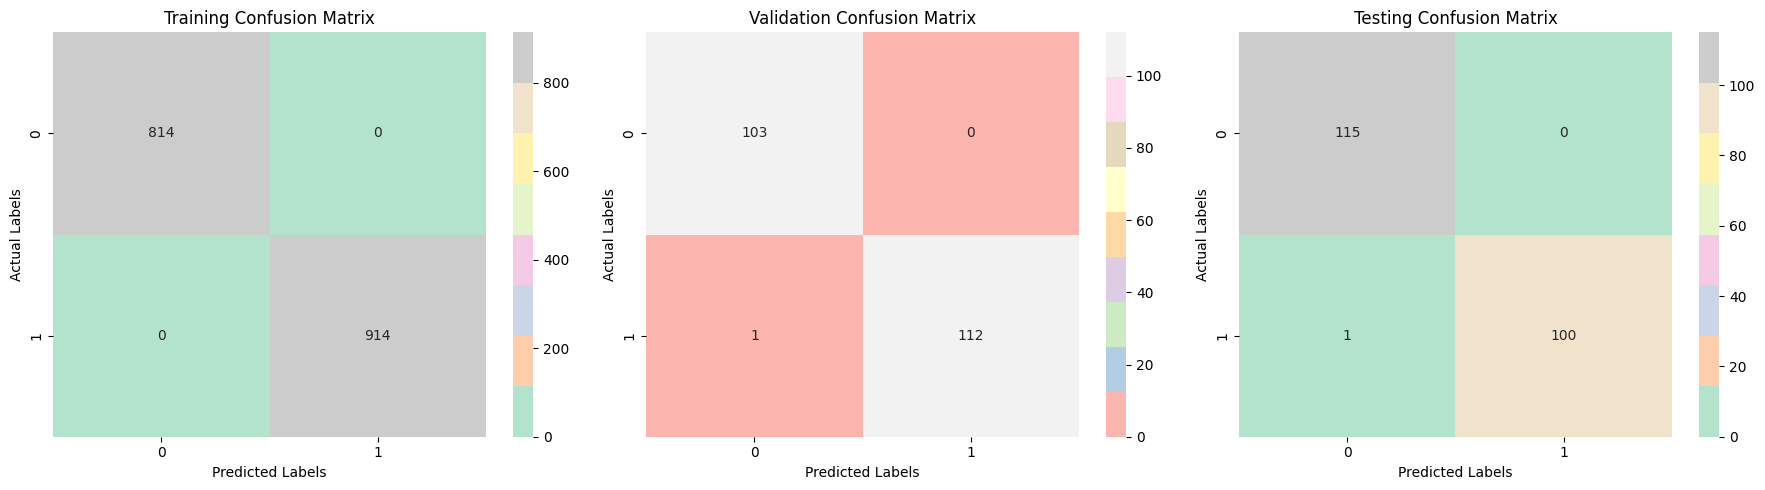

7/7 [==============================] - 1s 82ms/step
Training Set:
Accuracy: 1.0
F1 Score: 1.0
Loss: 0.00927326176315546


Validation Set:
Accuracy: 0.9953703703703703
F1 Score: 0.9955555555555555
Loss: 0.027837833389639854


Test Set:
Accuracy: 0.9953703703703703
F1 Score: 0.9950248756218906
Loss: 0.03143683820962906




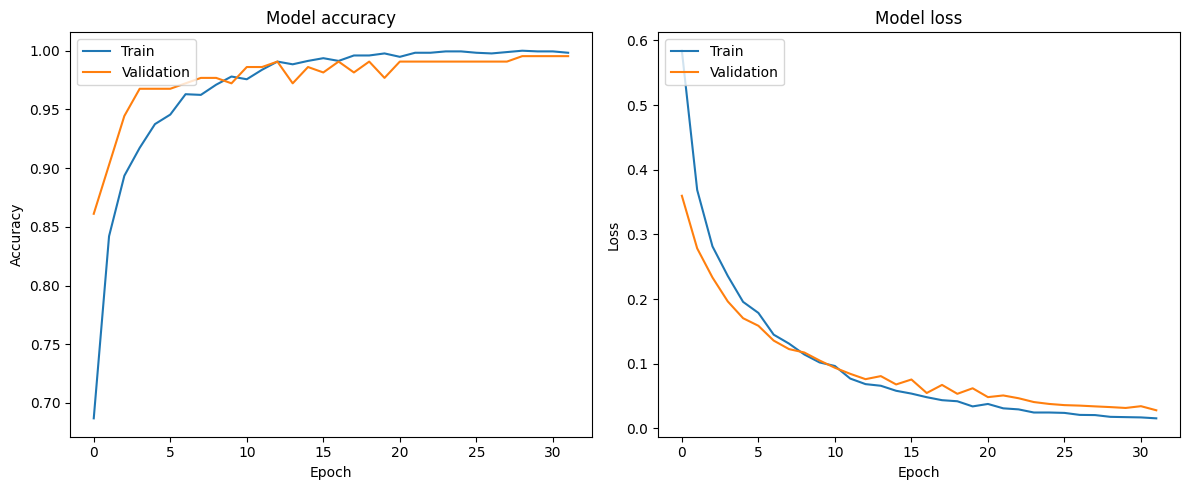

In [53]:
evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)
results = evaluate_model_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test)
for set_name, metrics in results.items():
    print(f"{set_name} Set:")
    #print("Confusion Matrix:")
    #print(metrics['Confusion Matrix'])
    print("Accuracy:", metrics['Accuracy'])
    print("F1 Score:", metrics['F1 Score'])
    print("Loss:", metrics['Loss'])
    print("\n")
plot_learning_curves(history)

## MobileNetV2

MobileNetV2 is a lightweight deep learning model designed for efficient deployment on resource-constrained devices like mobile phones and embedded systems. It leverages depth-wise separable convolutions to reduce computational complexity while maintaining high accuracy in image recognition tasks. This architecture allows MobileNetV2 to achieve state-of-the-art performance on various tasks, making it a popular choice for mobile applications requiring real-time image processing. Its compact size and impressive performance make it a versatile option for a wide range of computer vision applications on devices with limited computational resources.

In [54]:
def build_and_train_mobilenetv2(X_train, y_train, X_val, y_val, X_test, y_test):
    # Load the MobileNetV2 model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Define the final model
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=32, validation_data=(X_val, y_val))

    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_cm = tf.math.confusion_matrix(y_train, y_train_pred > 0.5)

    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    y_val_pred = model.predict(X_val)
    val_cm = tf.math.confusion_matrix(y_val, y_val_pred > 0.5)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    y_test_pred = model.predict(X_test)
    test_cm = tf.math.confusion_matrix(y_test, y_test_pred > 0.5)

    return train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, model, history

In [55]:
train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, model, history = build_and_train_mobilenetv2(X_train, y_train, X_val, y_val, X_test, y_test)


Epoch 1/32
54/54 [==============================] - 7s 57ms/step - loss: 0.5648 - accuracy: 0.7025 - val_loss: 0.3572 - val_accuracy: 0.8889
Epoch 2/32
54/54 [==============================] - 2s 31ms/step - loss: 0.3340 - accuracy: 0.8704 - val_loss: 0.2576 - val_accuracy: 0.9398
Epoch 3/32
54/54 [==============================] - 2s 31ms/step - loss: 0.2383 - accuracy: 0.9253 - val_loss: 0.2035 - val_accuracy: 0.9630
Epoch 4/32
54/54 [==============================] - 2s 31ms/step - loss: 0.1861 - accuracy: 0.9497 - val_loss: 0.1596 - val_accuracy: 0.9769
Epoch 5/32
54/54 [==============================] - 2s 31ms/step - loss: 0.1479 - accuracy: 0.9688 - val_loss: 0.1312 - val_accuracy: 0.9815
Epoch 6/32
54/54 [==============================] - 2s 31ms/step - loss: 0.1167 - accuracy: 0.9815 - val_loss: 0.1224 - val_accuracy: 0.9722
Epoch 7/32
54/54 [==============================] - 2s 31ms/step - loss: 0.0968 - accuracy: 0.9809 - val_loss: 0.0970 - val_accuracy: 0.9907
Epoch 8/32
54

7/7 [==============================] - 0s 24ms/step


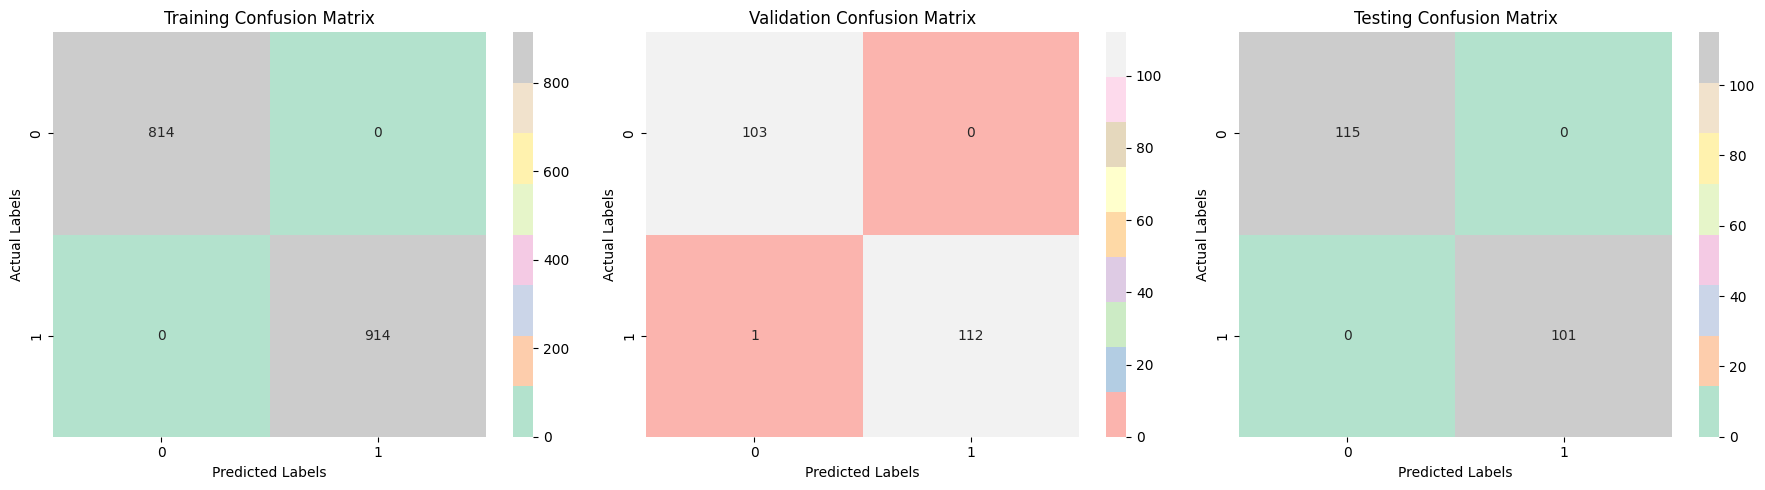

7/7 [==============================] - 0s 24ms/step
Training Set:
Accuracy: 1.0
F1 Score: 1.0
Loss: 0.0035981505643576384


Validation Set:
Accuracy: 0.9953703703703703
F1 Score: 0.9955555555555555
Loss: 0.0153629370033741


Test Set:
Accuracy: 1.0
F1 Score: 1.0
Loss: 0.004762138705700636




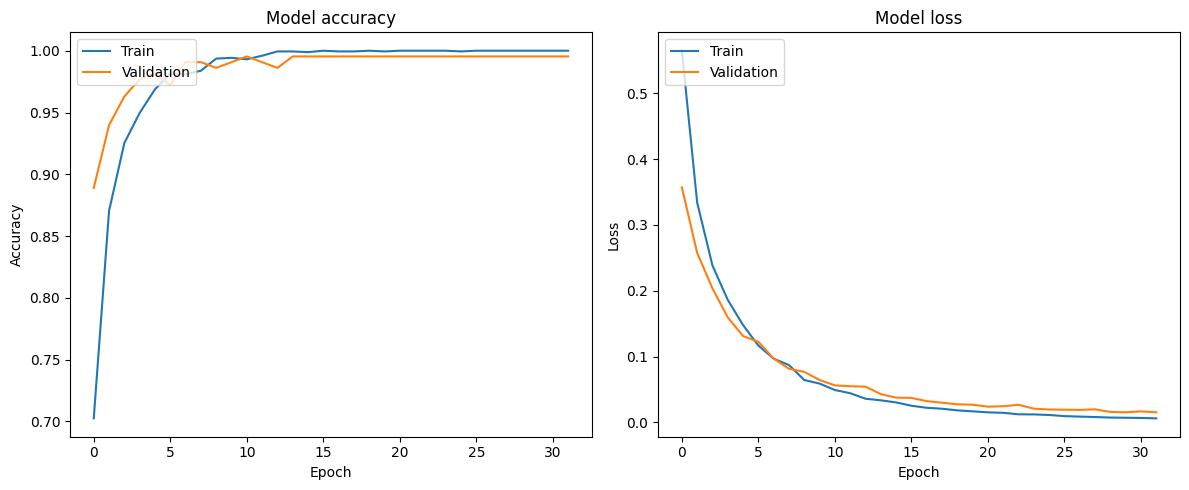

In [56]:
evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)
results = evaluate_model_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test)
for set_name, metrics in results.items():
    print(f"{set_name} Set:")
    #print("Confusion Matrix:")
    #print(metrics['Confusion Matrix'])
    print("Accuracy:", metrics['Accuracy'])
    print("F1 Score:", metrics['F1 Score'])
    print("Loss:", metrics['Loss'])
    print("\n")
plot_learning_curves(history)